# 라이브러리

In [52]:
import numpy as np
from scipy import stats
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import re
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from itertools import combinations

# 데이터 로드

In [53]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 파생변수 생성

In [54]:
train['대출기간'] = train['대출기간'].apply(lambda x: int(re.search(r'\d+', x).group()))
test['대출기간'] = test['대출기간'].apply(lambda x: int(re.search(r'\d+', x).group()))

train['월상환액_대출금액_비율'] = (train['총상환원금'] + train['총상환이자']) / (train['대출금액'] / (train['대출기간']))
test['월상환액_대출금액_비율'] = (test['총상환원금'] + test['총상환이자']) / (test['대출금액'] / (test['대출기간']))

train['상환_대비_대출금_비율'] = train['총상환원금'] / train['대출금액']
test['상환_대비_대출금_비율'] = test['총상환원금'] / test['대출금액']

train['대출_상환_비율'] = (train['총상환원금'] + train['총상환이자']) / train['대출금액']
test['대출_상환_비율'] = (test['총상환원금'] + test['총상환이자']) / test['대출금액']

# 통계 검정

In [55]:
df = train
df

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,월상환액_대출금액_비율,상환_대비_대출금_비율,대출_상환_비율
0,TRAIN_00000,12480000,36,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C,0.000000,0.000000,0.000000
1,TRAIN_00001,14400000,60,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B,2.531800,0.025943,0.042197
2,TRAIN_00002,12000000,36,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A,3.241764,0.077387,0.090049
3,TRAIN_00003,14400000,36,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C,1.197330,0.022627,0.033259
4,TRAIN_00004,18000000,60,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B,1.258320,0.012697,0.020972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,TRAIN_96289,14400000,36,10+ years,MORTGAGE,210000000,9.33,33,신용 카드,0,974580,492168.0,0.0,0.0,C,3.666870,0.067679,0.101858
96290,TRAIN_96290,28800000,60,10+ years,MORTGAGE,132000000,5.16,25,주택 개선,0,583728,855084.0,0.0,0.0,E,2.997525,0.020268,0.049959
96291,TRAIN_96291,14400000,36,1 year,MORTGAGE,84000000,11.24,22,신용 카드,0,1489128,241236.0,0.0,0.0,A,4.325910,0.103412,0.120164
96292,TRAIN_96292,15600000,36,5 years,MORTGAGE,66330000,17.30,21,부채 통합,2,1378368,818076.0,0.0,0.0,D,5.068717,0.088357,0.140798


In [56]:
import pandas as pd
from scipy.stats import f_oneway

# ANOVA 수행
result = f_oneway(df['대출금액'], df['부채_대비_소득_비율'], df['총계좌수'], df['연간소득'])
result

F_onewayResult(statistic=76983.42602684714, pvalue=0.0)

In [57]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 사후검정 수행
posthoc = pairwise_tukeyhsd(df['총상환원금'], df['대출등급'])
print(posthoc)


       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
group1 group2   meandiff   p-adj     lower        upper     reject
------------------------------------------------------------------
     A      B  -232951.875    0.0 -262175.2748 -203728.4752   True
     A      C -314858.5479    0.0   -344313.39 -285403.7059   True
     A      D -337248.9722    0.0 -372146.1367 -302351.8078   True
     A      E -359515.5636    0.0 -401598.4906 -317432.6366   True
     A      F  -399648.596    0.0 -471574.4984 -327722.6936   True
     A      G -479947.2829    0.0 -628596.8489 -331297.7169   True
     B      C  -81906.6729    0.0 -107243.4409   -56569.905   True
     B      D -104297.0973    0.0 -135795.9254  -72798.2691   True
     B      E -126563.6886    0.0 -165874.4611  -87252.9161   True
     B      F  -166696.721    0.0 -237036.6068  -96356.8353   True
     B      G -246995.4079    0.0 -394884.0741  -99106.7418   True
     C      D  -22390.4243 0.3636  -54104.0933    9323.2447  F

C:\Users\j_be_\.conda\envs\Dacon\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\j_be_\.conda\envs\Dacon\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\j_be_\.conda\envs\Dacon\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46321 (\N{HANGUL SYLLABLE DEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\j_be_\.conda\envs\Dacon\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\j_be_\.conda\envs\Dacon\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from current font.
  fig.canvas.print_figu

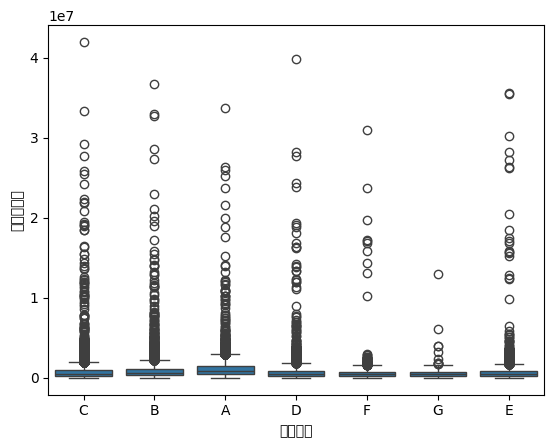

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# 대출등급에 따른 대출금액의 분포 시각화
sns.boxplot(x='대출등급', y='총상환원금', data=df)
plt.show()

In [59]:
# ANOVA(일원배치분산분석) 수행
cols =  df.select_dtypes(exclude='object').columns.tolist()

for col in cols:
    print(f'[대출등급, {col}] ANOVA')
    result = f_oneway(df[f'{col}'][df['대출등급'] == 'A'],
                      df[f'{col}'][df['대출등급'] == 'B'],
                      df[f'{col}'][df['대출등급'] == 'C'],
                      df[f'{col}'][df['대출등급'] == 'D'],
                      df[f'{col}'][df['대출등급'] == 'E'],
                      df[f'{col}'][df['대출등급'] == 'F'],
                      df[f'{col}'][df['대출등급'] == 'G'])

    print(result)

[대출등급, 대출금액] ANOVA
F_onewayResult(statistic=454.32713684334936, pvalue=0.0)
[대출등급, 대출기간] ANOVA
F_onewayResult(statistic=3979.5610674031786, pvalue=0.0)
[대출등급, 연간소득] ANOVA
F_onewayResult(statistic=149.0598282981811, pvalue=4.816027990915243e-189)
[대출등급, 부채_대비_소득_비율] ANOVA
F_onewayResult(statistic=52.436842586360484, pvalue=7.71758001370164e-65)
[대출등급, 총계좌수] ANOVA
F_onewayResult(statistic=67.41751230341222, pvalue=4.552665738933169e-84)
[대출등급, 최근_2년간_연체_횟수] ANOVA
F_onewayResult(statistic=66.8557345236643, pvalue=2.3985329094228896e-83)
[대출등급, 총상환원금] ANOVA
F_onewayResult(statistic=228.14375690297206, pvalue=1.610696070744567e-290)
[대출등급, 총상환이자] ANOVA
F_onewayResult(statistic=4205.829962669025, pvalue=0.0)
[대출등급, 총연체금액] ANOVA
F_onewayResult(statistic=16.773943224244498, pvalue=1.887031584881659e-19)
[대출등급, 연체계좌수] ANOVA
F_onewayResult(statistic=16.603108586261282, pvalue=3.0861763890808586e-19)
[대출등급, 월상환액_대출금액_비율] ANOVA
F_onewayResult(statistic=377.0259000288076, pvalue=0.0)
[대출등급, 상환_대비_대

In [60]:
df = train
def chi2_test(dependent_var, independent_var):
    contingency_table = pd.crosstab(df[dependent_var], df[independent_var])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    return chi2, p

# 예시: 대출등급과 주택소유상태 간의 카이제곱 검정 수행
cols = df.select_dtypes(include = object).columns
for col in cols:
    print(f'[대출등급, {col}]')
    chi2_stat, p_value = chi2_test('대출등급', col)
    print(f"Chi2 Statistic: {chi2_stat}")
    print(f"P-value: {p_value}")


[대출등급, ID]
Chi2 Statistic: 577763.9999999998
P-value: 0.49752584642206804
[대출등급, 근로기간]
Chi2 Statistic: 187.56633181905977
P-value: 7.714129711631081e-09
[대출등급, 주택소유상태]
Chi2 Statistic: 663.4327372511038
P-value: 3.225488826409481e-129
[대출등급, 대출목적]
Chi2 Statistic: 5744.213056799291
P-value: 0.0
[대출등급, 대출등급]
Chi2 Statistic: 577764.0000000001
P-value: 0.0


In [61]:
df = train
def chi2_test(dependent_var, independent_var):
    contingency_table = pd.crosstab(df[dependent_var], df[independent_var])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    return chi2, p

# 예시: 대출등급과 주택소유상태 간의 카이제곱 검정 수행
cols = df.select_dtypes(include = object).columns
for col in cols:
    print(f'>>>>>>>>>>>>>>>>>{col} 검정 시작>>>>>>>>>>>>>>>>>')
    chi2_stat, p_value = chi2_test('대출등급', col)
    print(f"Chi2 Statistic: {chi2_stat}")
    print(f"P-value: {p_value}")

def t_test(dependent_var, independent_var):
    group1 = df[df[dependent_var] == 'A'][independent_var]
    group2 = df[df[dependent_var] == 'B'][independent_var]
    t_stat, p_value = ttest_ind(group1, group2, equal_var=False)  # 등분산 가정 안 함
    return t_stat, p_value

cols = df.select_dtypes(exclude = object).columns
for col in cols:
    print(f'>>>>>>>>>>>>>>>>>{col} 검정 시작>>>>>>>>>>>>>>>>>')
    t_stat, p_value = t_test('대출등급', col)
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}")

>>>>>>>>>>>>>>>>>ID 검정 시작>>>>>>>>>>>>>>>>>
Chi2 Statistic: 577763.9999999998
P-value: 0.49752584642206804
>>>>>>>>>>>>>>>>>근로기간 검정 시작>>>>>>>>>>>>>>>>>
Chi2 Statistic: 187.56633181905977
P-value: 7.714129711631081e-09
>>>>>>>>>>>>>>>>>주택소유상태 검정 시작>>>>>>>>>>>>>>>>>
Chi2 Statistic: 663.4327372511038
P-value: 3.225488826409481e-129
>>>>>>>>>>>>>>>>>대출목적 검정 시작>>>>>>>>>>>>>>>>>
Chi2 Statistic: 5744.213056799291
P-value: 0.0
>>>>>>>>>>>>>>>>>대출등급 검정 시작>>>>>>>>>>>>>>>>>
Chi2 Statistic: 577764.0000000001
P-value: 0.0
>>>>>>>>>>>>>>>>>대출금액 검정 시작>>>>>>>>>>>>>>>>>
T-statistic: 11.279409144817087
P-value: 1.8557439688926076e-29
>>>>>>>>>>>>>>>>>대출기간 검정 시작>>>>>>>>>>>>>>>>>
T-statistic: -54.028589761779614
P-value: 0.0
>>>>>>>>>>>>>>>>>연간소득 검정 시작>>>>>>>>>>>>>>>>>
T-statistic: 13.149245118776847
P-value: 2.2068624911263098e-39
>>>>>>>>>>>>>>>>>부채_대비_소득_비율 검정 시작>>>>>>>>>>>>>>>>>
T-statistic: -20.88524996571793
P-value: 2.593439782473503e-96
>>>>>>>>>>>>>>>>>총계좌수 검정 시작>>>>>>>>>>>>>>>>>
T-statistic: 14.7

# 변수 선택

In [62]:
train.drop(columns = ['연체계좌수', '최근_2년간_연체_횟수', '주택소유상태', '대출목적', '총계좌수', '근로기간', '총연체금액'], inplace=True)
test.drop(columns = ['연체계좌수', '최근_2년간_연체_횟수', '주택소유상태', '대출목적', '총계좌수', '근로기간', '총연체금액'], inplace=True)

train.set_index('ID', inplace=True)
test.set_index('ID', inplace=True)

# 이상치 처리 및 스케일링

In [63]:
def remove_outliers(data, column_name, grade_column='대출등급', alpha=0.00044):
  data_no_outliers = pd.DataFrame()
  for grade in data[grade_column].unique():
      subset = data[data[grade_column] == grade]
      lower_limit = subset[column_name].quantile(alpha / 2)
      upper_limit = subset[column_name].quantile(1 - alpha / 2)
      subset_no_outliers = subset[(subset[column_name] >= lower_limit) & (subset[column_name] <= upper_limit)]
      data_no_outliers = pd.concat([data_no_outliers, subset_no_outliers])
  return data_no_outliers
cols = train.select_dtypes(exclude=object).columns
for col in cols:
  train = remove_outliers(train, col, '대출등급')

cols = train.select_dtypes(exclude=object).columns
scaler = MinMaxScaler()
train[cols] = scaler.fit_transform(train[cols])
test[cols] = scaler.transform(test[cols])

# tenure_mapping = {
#     '10+ years': 11,
#     '2 years': 3,
#     '< 1 year': 1,
#     '3 years': 4,
#     '1 year': 2,
#     'Unknown': 0,
#     '5 years': 6,
#     '4 years': 5,
#     '8 years': 9,
#     '6 years': 7,
#     '7 years': 8,
#     '9 years': 10,
#     '10+years': 11,
#     '<1 year': 1,
#     '3': 4,
#     '1 years': 2
# }
# train['근로기간'] = train['근로기간'].map(tenure_mapping)
# test['근로기간'] = test['근로기간'].map(tenure_mapping)

# 라벨링

In [64]:
if '대출목적' in test.columns:
  test['대출목적'] = test['대출목적'].replace('결혼', '휴가')

# cols = test.select_dtypes(include=object).columns
# for col in cols:
#     le = LabelEncoder()
#     train[col] = le.fit_transform(train[col])
#     test[col] = le.transform(test[col])

map_list = {'A' : 6, 'B' : 5, 'C' : 4, 'D' : 3,  'E' : 2,  'F' : 1, 'G' : 0}
for key, item in map_list.items():
  train['대출등급'] = train['대출등급'].replace(key, item)

In [65]:
X = train.drop(columns=['대출등급'])
y = train['대출등급']

# 클래스 불균형 문제 해결 (사용안함)

In [66]:
# sampling_strategy_under = {
#   0: y.value_counts()[0],
#   1: y.value_counts()[1],
#   2: y.value_counts()[2]-(i*100),
#   3: y.value_counts()[3]-(i*450),
#   4: y.value_counts()[4]-(i*1000),
#   5: y.value_counts()[5]-(i*1000),
#   6: y.value_counts()[6]-(i*500)
# }

# sampling_strategy_over = {
#     0: y.value_counts()[0]+(10*i),
#     1: y.value_counts()[1]+(20*i),
#     2: y.value_counts()[2]+(30*i),
#     3: y.value_counts()[3],
#     4: y.value_counts()[4],
#     5: y.value_counts()[5],
#     6: y.value_counts()[6]
# }

# 오버샘플링
# smote = SMOTE(sampling_strategy=sampling_strategy_over, random_state=1111)
# smote = SMOTE(random_state=1111)
# smote = SMOTETomek(tomek=TomekLinks(sampling_strategy='auto'))
# X, y = smote.fit_resample(X, y)


# 언더샘플링
# under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy_under,random_state=1111)
# X, y = under_sampler.fit_resample(X, y)
# print(y.value_counts())

# 5-fold 교차 검증

In [67]:
# # 5-fold 교차 검증을 위한 StratifiedKFold 객체 생성
# mac_f1score = []
# best_model = None
# best_score = 0.0
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# for i, (train_index, val_index) in enumerate(kfold.split(X, y)):
#   X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
#   y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
#
#   # 모델 생성 및 훈련
#   model = RandomForestClassifier(n_estimators= 190,
#                                 max_depth=15,
#                                 min_samples_split = 4,
#                                 # max_features  = None,
#                                 random_state=1111
#                                 )
#
#   model.fit(X_train_fold, y_train_fold)
#
#   # 검증 세트에 대한 예측
#   pred_val = model.predict(X_val_fold)
#
#   # 검증 세트 정확도 평가
#   # pred_val = np.round(pred_val) # regressor
#   mac_f1 = f1_score(y_val_fold, pred_val, average='macro')
#   print(f'{i+1} Fold macro f1 score: {mac_f1}')
#   mac_f1score.append(mac_f1)
#
# print('5-fold 평균 macro f1 score:', sum(mac_f1score) / len(mac_f1score))

# 결과

In [68]:
# 모델 생성 및 훈련
model = RandomForestClassifier(n_estimators= 190,
                              max_depth=15,
                              min_samples_split = 4,
                              max_features  = None,
                              random_state=1111
                              )

model.fit(X, y)
pred = model.predict(test)

sub = pd.read_csv('sample_submission.csv')
sub['대출등급'] = pred
for key, item in map_list.items():
    sub['대출등급'] = sub['대출등급'].replace(item, key)
sub

,ID,대출등급
0,TEST_00000,B
1,TEST_00001,B
2,TEST_00002,A
3,TEST_00003,C
4,TEST_00004,C
...,...,...
64192,TEST_64192,D
64193,TEST_64193,D
64194,TEST_64194,D
64195,TEST_64195,C


In [71]:
sub.to_csv('sub.csv', index=False)

C:\Users\j_be_\AppData\Local\Temp\ipykernel_26596\2052720613.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = sub['대출등급'].value_counts().sort_index().index, y = sub['대출등급'].value_counts().sort_index(),


ValueError: keyword grid_line_style is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

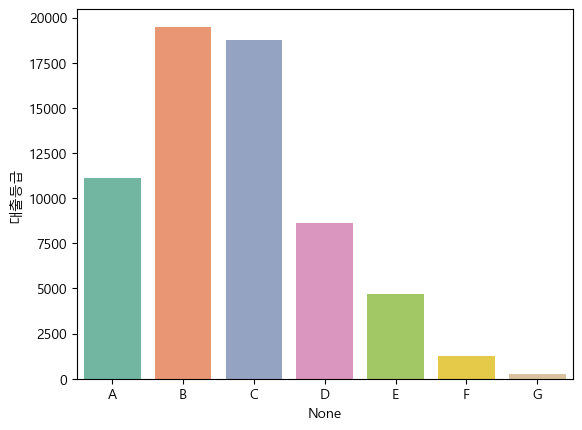

In [69]:
plt.rcParams['font.family'] = 'Malgun Gothic'
sns.barplot(x = sub['대출등급'].value_counts().sort_index().index, y = sub['대출등급'].value_counts().sort_index(),
            palette='Set2')
plt.grid(True, alpha=0.6, line_style='--')
plt.ylabel('Count')
plt.xlabel('대출등급')
plt.tight_layout()
plt.show()

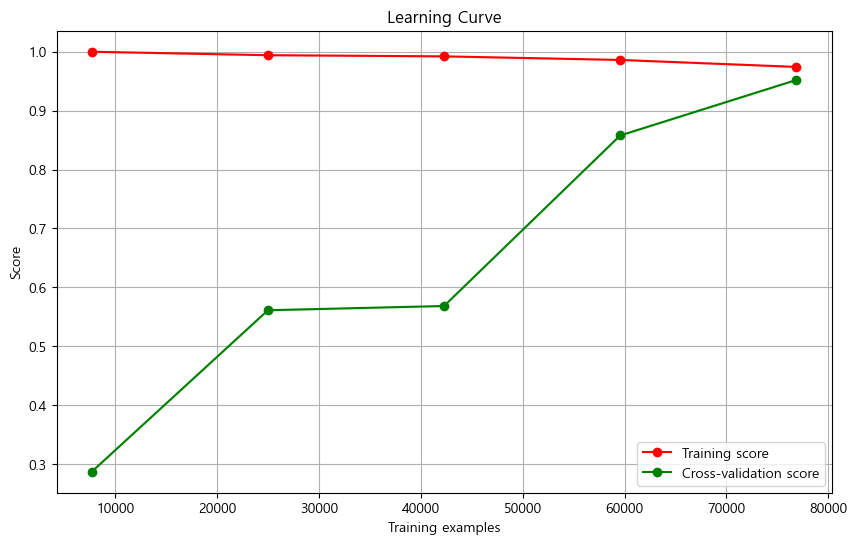

In [72]:
from sklearn.metrics import f1_score, make_scorer

# 매크로 F1 점수를 계산하는 함수
def macro_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

# Learning Curve를 그리는 함수 (매크로 F1 Score 기준)
def plot_learning_curve_f1(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Macro F1 Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=make_scorer(macro_f1_score))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt
# 모델 생성
model = RandomForestClassifier(n_estimators=190,
                               max_depth=15,
                               min_samples_split=4,
                               max_features=None,
                               random_state=1111)
# Learning Curve 그리기 (매크로 F1 Score 기준)
plot_learning_curve_f1(model, "Learning Curve (Macro F1 Score)", X, y, cv=5, n_jobs=-1)

plt.show()
